Try to implement the functions and complete lines with "###"

In [19]:
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib as mpl
#mpl.rcParams['text.usetex'] = True
#mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsfonts}']
%matplotlib inline

### Exercise 2.1

What is the distribution of the number of fair coin tosses before one observes 3 heads in a row? To solve this, consider a 4-state Markov chain with transition probability matrix
$$
    P = 
    \begin{bmatrix}
        0.5 & 0.5 & 0 & 0 \\
        0.5 & 0 & 0.5 & 0 \\
        0.5 & 0 & 0 & 0.5 \\
        0 & 0 & 0 & 1
    \end{bmatrix}
$$
where $ X_t = 1 $ if the previous toss was tails, $ X_t = 2 $ if the last two tosses were tails then heads, $ X_t = 3 $ if the last three tosses were tails then heads twice, and $ X_t = 4 $ is an absorbing state that is reached when the last three tosses are heads. 

* Write a computer program (e.g., in Python, Matlab, ...) to compute $ \Pr(T_{1,4} = m) $ for $ m = 1, 2, \ldots, 100 $ and use this to estimate expected number of tosses $ \mathbb{E}[T_{1,4}] $. 

13.970568255020405


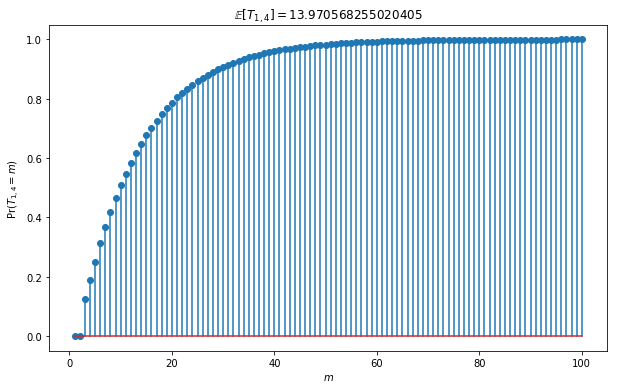

In [20]:
def compute_Phi_ET(P, ns=100):
    '''
    Arguments:
        P {numpy.array} -- n x n, transition matrix of the Markov chain
        ns {int} -- largest step to consider

    Returns:
        Phi_list {numpy.array} -- (ns + 1) x n x n, the Phi matrix for time 0, 1, ...,ns
        ET {numpy.array} -- n x n, expectedd hitting time approxiamated up to step ns
    '''
    # Try to compute following quantities:
    # Phi_list[m, i, j] = phi_{i,j}^{(m)} = Pr( T_{i, j} <= m )
    # ET[i, j] = E[ T_{i, j} ] ~ \sum_{m=1}^ns m Pr( T_{i, j} = m )
    # Notice in python the index starts from 0
    n = len(P)
    Phi_list = np.zeros((ns+1,n,n))
    Phi_list[0] = np.identity(n)
    Phi = np.zeros((ns+1,n,n))
    for m in range (1,ns+1):
        Phi_list[m] = np.dot(Phi_list[m-1],P)#calculate Pr( T_{i, j} <= m )
        Phi[m] = Phi_list[m] - Phi_list[m-1]
    ET = np.zeros((n,n))
    for m in range (1,ns+1):
        ET += m * Phi[m]
    return Phi_list, ET
    
P = np.array([[0.5, 0.5, 0, 0], [0.5, 0, 0.5, 0], [0.5, 0, 0, 0.5], [0, 0, 0, 1]])  
Phi_list, ET = compute_Phi_ET(P, 100)

m = range (1,101) ### steps to be plotted
Pr = []
for i in m:
    Pr.append(Phi_list[i][0][3])
 #Pr= ### \Pr(T_{1,4} = m) for all m
E = ET[0][3]### \mathbb{E}[T_{1,4}]
print(E)

plt.figure(figsize=(10, 6))
plt.stem(m, Pr)
plt.xlabel(r'$ m $')
plt.ylabel(r'$ \Pr(T_{1,4}=m) $')
plt.title(r'$ \mathbb{E}[T_{1,4}] = ' + str(E) + ' $');

* Write a computer program that generates 500 realizations from this Markov chain and uses them to plots a histogram of $ T_{1,4} $.

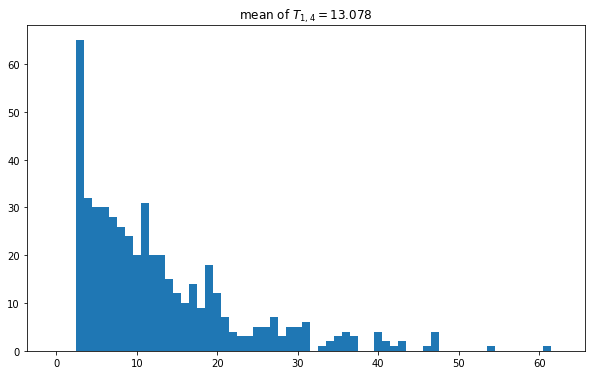

In [21]:
def simulate_hitting_time(P, states, nr):
    '''
    Arguments:
        P {numpy.array} -- n x n, transition matrix of the Markov chain
        states {list[int]} -- the list [start state, end state], index starts from 0
        nr {int} -- largest step to consider

    Returns:
        T {list[int]} -- a size nr list contains the hitting time of all realizations
    '''
    start, end = states
    if start == end: return [0] * nr
    # Try to simulate following quantities:
    # T[i] = hitting time of the i-th realization
    # Notice in python the index starts from 0
    T=[]
    n=len(P)
    sumPr=np.zeros((n,n))
    for i in range(0,n):
        sumPr[i][0]=P[i][0]
        for j in range(1,n):
            sumPr[i][j]=P[i][j]+sumPr[i][j-1] # counting P(i,j) sums of P[n x n]  
    k=1
    while k<=nr:#500 loop
        count=0        
        current=start
        while current!=end:# one relization loop
            u=np.random.rand()
            count+=1
            index=np.where(sumPr[current]>u) # find the index of the first number which is bigger than u
            current=index[0][0]
        T.append(count)
        k=k+1
    return T
     
T = simulate_hitting_time(P, [0, 3], 500)
plt.figure(figsize=(10, 6))
plt.hist(T, bins=np.arange(max(T))-0.5)
plt.title(r'mean of $ T_{1,4} = ~ $' + str(np.mean(T)));

### Exercise 2.2

Consider the miniature chutes and ladders game shown in Figure 1. 
Assume a player starts on the space labeled 1 and plays by rolling a fair four-sided die and then moves that number of spaces. 
If a player lands on the bottom of a ladder, then they automatically climb to the top. 
If a player lands at the top of a slide, then they automatically slide to the bottom. 
This process can be modeled by a Markov chain with $ n = 16 $ states where each state is associated with a square where players can start their turn (e.g., players never start at the bottom of a ladder or the top of a slide). 
To finish the game, players must land exactly on space 20 (moves beyond this are not taken). 

* Compute the transition probability matrix $ P $ of the implied Markov chain. 

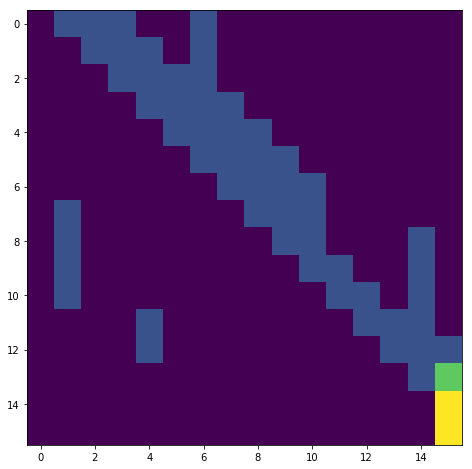

In [22]:
def construct_P_matrix(n, dice, chutes, ladders):
    '''
    Arguments:
        n {int} -- size of the state space
        dice {numpy.array} -- probability distribution of the dice outcome
        chutes {list[(int, int)]} -- the list of chutes, in pairs of (start, end)
        ladders {list[(int, int)]} -- the list of ladders, in pairs of (start, end)

    Returns:
        P {numpy.array} -- n x n, transition matrix of the Markov chain
    '''
    # Construct the transition matrix of the chutes & ladders game
    P1=([
        [0,0.25,0.25,0.25,0,0,0.25,0,0,0,0,0,0,0,0,0],
        [0,0,0.25,0.25,0.25,0,0.25,0,0,0,0,0,0,0,0,0],
        [0,0,0,0.25,0.25,0.25,0.25,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0.25,0.25,0.25,0.25,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0.25,0.25,0.25,0.25,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0.25,0.25,0.25,0.25,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0.25,0.25,0.25,0.25,0,0,0,0,0],
        [0,0.25,0,0,0,0,0,0,0.25,0.25,0.25,0,0,0,0,0],
        [0,0.25,0,0,0,0,0,0,0,0.25,0.25,0,0,0,0.25,0],
        [0,0.25,0,0,0,0,0,0,0,0,0.25,0.25,0,0,0.25,0],
        [0,0.25,0,0,0,0,0,0,0,0,0,0.25,0.25,0,0.25,0],
        [0,0,0,0,0.25,0,0,0,0,0,0,0,0.25,0.25,0.25,0],
        [0,0,0,0,0.25,0,0,0,0,0,0,0,0,0.25,0.25,0.25],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.25,0.75],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]
    ])
    return P1

n = 16### number of states
dice =([0.25,0.25,0.25,0.25]) ### probability distribution of dice
chutes = [(13,2),(17,6)]### (sorce, destination) pairs of chutes
ladders = [(4,8),(14,19)]### (sorce, destination) pairs of ladders

P1 = construct_P_matrix(n, dice, chutes, ladders)
plt.figure(figsize=(8, 8))
plt.imshow(P1)

* For this Markov chain, write a computer program (e.g., in Python, Matlab, ...) to compute the cumulative distribution of the number turns a player takes to finish (i.e., the probability $ \Pr(T_{1, 20} \le m) $ where $ T_{1, 20} $ is the hitting time from state 1 to state 20).


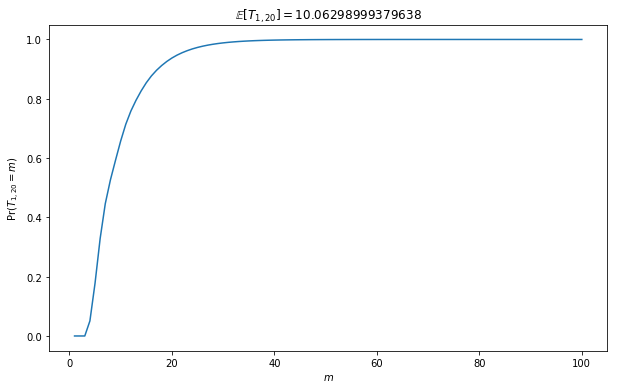

In [23]:
Phi_list1, ET1 = compute_Phi_ET(P1, ns=100)

m = range(1,101)### steps to be plotted
Pr1 = []### \Pr(T_{1,20} <= m) for all m
for i in m:
    Pr1.append(Phi_list1[i][0][15])
E = ET1[0][15]### \mathbb{E}[T_{1,20}]

plt.figure(figsize=(10, 6))
plt.plot(m ,Pr1)
plt.xlabel(r'$ m $')
plt.ylabel(r'$ \Pr(T_{1,20}=m) $')
plt.title(r'$ \mathbb{E}[T_{1,20}] = ' + str(E) + ' $');

* Write a computer program that generates 500 realizations from this Markov chain and uses them to plot a histogram of $ T_{1, 20} $.


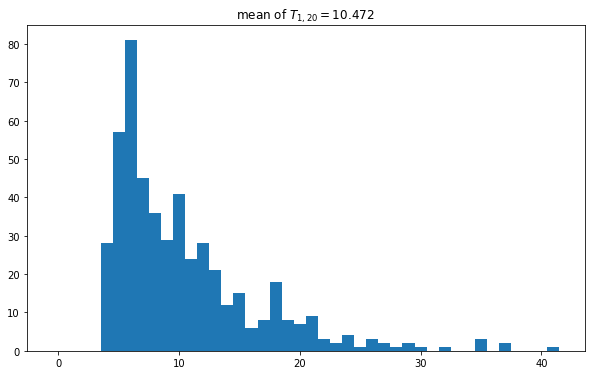

In [24]:
T = simulate_hitting_time(P1, [0, 15], 500)
plt.figure(figsize=(10, 6))
plt.hist(T, bins=np.arange(max(T))-0.5)
plt.title(r'mean of $ T_{1,20} = ~ $' + str(np.mean(T)));

* Optional Challenge: If the ﬁrst player rolls 4 and climbs the ladder to square 8, then what is the probability that the second player will win.

In [ ]:
Pr_win = 0
### compute Pr_win
Pr_win

### Exercise 2.3

In a certain city, it is said that the weather is rainy with a 90% probability if it was rainy the previous day and with a 50% probability if it not rainy the previous day. 
If we assume that only the previous day’s weather matters, then we can model the weather of this city by a Markov chain with $ n = 2 $ states whose transitions are governed by
$$
    P = 
    \begin{bmatrix}
        0.9 & 0.1 \\
        0.5 & 0.5
    \end{bmatrix}
$$
Under this model, what is the steady-state probability of rainy weather?


In [25]:
def stationary_distribution(P):
    '''
    Arguments:
        P {numpy.array} -- n x n, transition matrix of the Markov chain

    Returns:
        pi {numpy.array} -- length n, stationary distribution of the Markov chain
    '''
    # Think pi as column vector, solve linear equations:
    #     P^T pi = pi
    #     sum(pi) = 1
    n=len(P)
    I=np.identity(n)
    trP=np.zeros((n))
    trP=(P-I)
    I1=np.ones(n)
    trP=np.c_[trP,I1]
    orth=np.dot(trP,trP.T)# orthogonality to solve linear equation
    x = np.linalg.solve(orth, I1)
    pi=x
    return pi

P = np.array([[0.9, 0.1], [0.5, 0.5]])
stationary_distribution(P)

array([0.83333333, 0.16666667])

### Exercise 2.4

Consider a game where the gameboard has 8 diﬀerent spaces arranged in a circle. 
During each turn, a player rolls two 4-sided dice and moves clockwise by a number of spaces equal to their sum. 
Deﬁne the transition matrix for this 8-state Markov chain and compute its stationary probability distribution.

In [26]:
P = ([                                  ### construct the transition matrix
    [1/16,0,1/16,1/8,1/5,1/4,1/5,1/8], 
    [1/8,1/16,0,1/16,1/8,1/5,1/4,1/5],
    [1/5,1/8,1/16,0,1/16,1/8,1/5,1/4],
    [1/4,1/5,1/8,1/16,0,1/16,1/8,1/5],
    [1/5,1/4,1/5,1/8,1/16,0,1/16,1/8],
    [1/8,1/5,1/4,1/5,1/8,1/16,0,1/16],
    [1/16,1/8,1/5,1/4,1/5,1/8,1/16,0],
    [0,1/16,1/8,1/5,1/4,1/5,1/8,1/16]])
    
print(P)
stationary_distribution(P)

[[0.0625, 0, 0.0625, 0.125, 0.2, 0.25, 0.2, 0.125], [0.125, 0.0625, 0, 0.0625, 0.125, 0.2, 0.25, 0.2], [0.2, 0.125, 0.0625, 0, 0.0625, 0.125, 0.2, 0.25], [0.25, 0.2, 0.125, 0.0625, 0, 0.0625, 0.125, 0.2], [0.2, 0.25, 0.2, 0.125, 0.0625, 0, 0.0625, 0.125], [0.125, 0.2, 0.25, 0.2, 0.125, 0.0625, 0, 0.0625], [0.0625, 0.125, 0.2, 0.25, 0.2, 0.125, 0.0625, 0], [0, 0.0625, 0.125, 0.2, 0.25, 0.2, 0.125, 0.0625]]


array([0.12499024, 0.12499024, 0.12499024, 0.12499024, 0.12499024,
       0.12499024, 0.12499024, 0.12499024])

Next, suppose that one space is special (e.g., state-1 of the Markov chain) and a player can only leave this space by rolling doubles (i.e., when both dice show the same value). Again, the player moves clockwise by a number of spaces equal to their sum. Deﬁne the transition matrix for this 8-state Markov chain and compute its stationary probability distribution.

In [32]:
P = ([ 
    [13/16,0,1/16,0,1/16,0,1/16,0], 
    [1/8,1/16,0,1/16,1/8,1/5,1/4,1/5],
    [1/5,1/8,1/16,0,1/16,1/8,1/5,1/4],
    [1/4,1/5,1/8,1/16,0,1/16,1/8,1/5],
    [1/5,1/4,1/5,1/8,1/16,0,1/16,1/8],
    [1/8,1/5,1/4,1/5,1/8,1/16,0,1/16],
    [1/16,1/8,1/5,1/4,1/5,1/8,1/16,0],
    [0,1/16,1/8,1/5,1/4,1/5,1/8,1/16]])### construct the transition matrix
print(P)
stationary_distribution(P)

[[0.8125, 0, 0.0625, 0, 0.0625, 0, 0.0625, 0], [0.125, 0.0625, 0, 0.0625, 0.125, 0.2, 0.25, 0.2], [0.2, 0.125, 0.0625, 0, 0.0625, 0.125, 0.2, 0.25], [0.25, 0.2, 0.125, 0.0625, 0, 0.0625, 0.125, 0.2], [0.2, 0.25, 0.2, 0.125, 0.0625, 0, 0.0625, 0.125], [0.125, 0.2, 0.25, 0.2, 0.125, 0.0625, 0, 0.0625], [0.0625, 0.125, 0.2, 0.25, 0.2, 0.125, 0.0625, 0], [0, 0.0625, 0.125, 0.2, 0.25, 0.2, 0.125, 0.0625]]


array([0.42066071, 0.08230743, 0.10209528, 0.07045945, 0.09236178,
       0.06248082, 0.0952795 , 0.07432879])